<a href="https://colab.research.google.com/github/nsanidhya1/DataTalk/blob/main/DataTalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install --upgrade google-genai pandas


In [14]:
from google import genai
import sqlite3
import pandas as pd
API_KEY = "YOUR_API_KEY"   #ENTER YOUR API KEY

client = genai.Client(api_key=API_KEY)
print("✅ Gemini initialized with API key")



✅ Gemini initialized with API key


In [15]:
from google.colab import files

# Upload a CSV file
uploaded = files.upload()

# Pick first file
filename = list(uploaded.keys())[0]

# Read CSV
df = pd.read_csv(filename)
print("✅ CSV loaded, preview:")
print(df.head())

# Save to SQLite
conn = sqlite3.connect("data.db")
table_name = "data"
df.to_sql(table_name, conn, if_exists="replace", index=False)

# Generate schema string
schema = f"{table_name}(" + ", ".join([f"{col} TEXT" for col in df.columns]) + ")"
print("✅ Schema:", schema)


Saving data.csv to data.csv
✅ CSV loaded, preview:
   Duration          Date  Pulse  Maxpulse  Calories
0        60  '2020/12/01'    110       130     409.1
1        60  '2020/12/02'    117       145     479.0
2        60  '2020/12/03'    103       135     340.0
3        45  '2020/12/04'    109       175     282.4
4        45  '2020/12/05'    117       148     406.0
✅ Schema: data(Duration TEXT, Date TEXT, Pulse TEXT, Maxpulse TEXT, Calories TEXT)


In [22]:
def nl_to_sql(nl_query, schema):
    resp = client.models.generate_content(
        model="gemini-1.5-flash",
        contents=f"Translate into SQL.\nSchema: {schema}\nQuestion: {nl_query}"
    )
    return resp.text.strip()

# Example query
question = "Show me the average Calories burned grouped by Duration."
def clean_sql(gemini_output):
    # Remove markdown fences and explanations
    sql = gemini_output.replace("```sql", "").replace("```", "").strip()
    return sql.split(";")[0] + ";"  # Keep only the first SQL statement

sql_query = nl_to_sql(question, schema)
print("Generated by Gemini:\n", sql_query)

# Clean the SQL before execution
sql_query = clean_sql(sql_query)
print("\nCleaned SQL:\n", sql_query)

# Run query
result = pd.read_sql_query(sql_query, conn)
print("\nResult:\n", result)


Generated by Gemini:
 ```sql
SELECT Duration, AVG(CAST(Calories AS REAL)) AS AverageCalories
FROM data
GROUP BY Duration;
```

This SQL query does the following:

* **`SELECT Duration, AVG(CAST(Calories AS REAL)) AS AverageCalories`**: This selects the `Duration` column and calculates the average of the `Calories` column.  Crucially, `CAST(Calories AS REAL)` converts the `Calories` column (presumably stored as text) into a numeric type (REAL) so that the `AVG()` function can work correctly.  The result is aliased as `AverageCalories`.

* **`FROM data`**: This specifies that the data should be retrieved from the `data` table.

* **`GROUP BY Duration`**: This groups the results by `Duration`, so the average Calories are calculated separately for each unique duration value.


If `Calories` were already a numeric type in your table (e.g., INT, FLOAT, DOUBLE), you could omit the `CAST` function:

```sql
SELECT Duration, AVG(Calories) AS AverageCalories
FROM data
GROUP BY Duration;
```

Clea

Result:
    Duration  AverageCalories
0        30        195.10000
1        45        291.88000
2        60        314.46087
3       450        253.30000


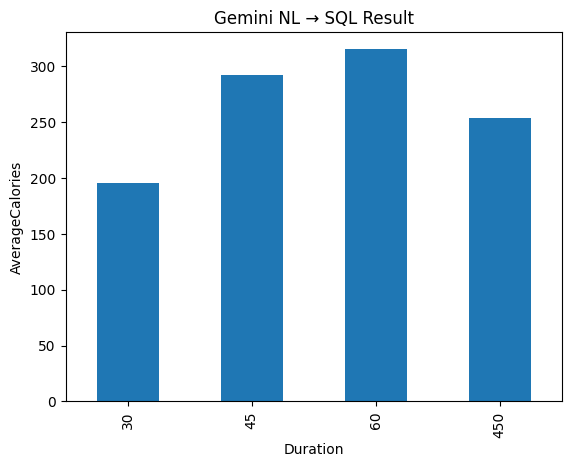

In [23]:
def run_sql(sql):
    try:
        return pd.read_sql_query(sql, conn)
    except Exception as e:
        return str(e)

result = run_sql(sql_query)
print("Result:\n", result)

import matplotlib.pyplot as plt

if isinstance(result, pd.DataFrame) and not result.empty:
    result.plot(kind="bar", x=result.columns[0], y=result.columns[1], legend=False)
    plt.ylabel(result.columns[1])
    plt.title("Gemini NL → SQL Result")
    plt.show()


In [27]:
!pip install gradio --quiet

import gradio as gr
import pandas as pd
import sqlite3
from google import genai
API_KEY = "YOUR_API_KEY"   #ENTER YOUR API KEY
client = genai.Client(api_key=API_KEY)

# --- Core Function ---
def ask_csv(file, question):
    try:
        # Load CSV
        df = pd.read_csv(file.name)
        conn = sqlite3.connect("data.db")
        df.to_sql("data", conn, if_exists="replace", index=False)

        # Build schema
        schema = "data(" + ", ".join([f"{c} TEXT" for c in df.columns]) + ")"

        # Call Gemini
        resp = client.models.generate_content(
            model="gemini-1.5-flash",
            contents=f"Return ONLY SQL. No explanation. Schema: {schema}\nQuestion: {question}"
        )

        sql = resp.text.strip().replace("```sql", "").replace("```", "")

        # Run SQL
        result = pd.read_sql_query(sql, conn)

        # Try plotting if possible
        plot_path = None
        if result.shape[1] >= 2:  # at least 2 columns
            try:
                plt.figure(figsize=(6,4))
                result.plot(kind="bar", x=result.columns[0], y=result.columns[1], legend=False)
                plt.xlabel(result.columns[0])
                plt.ylabel(result.columns[1])
                plt.title("Query Result")
                plot_path = "plot.png"
                plt.savefig(plot_path)
                plt.close()
            except Exception as e:
                plot_path = None

        return f"🔹 Generated SQL:\n\n{sql}", result, plot_path

    except Exception as e:
        return f"❌ Error: {str(e)}", None, None

# --- Gradio UI ---
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        <div style="text-align: center">
        <h1>🧠 Ask Your CSV with Gemini</h1>
        <p>Upload a CSV → Ask in plain English → Get SQL + Results 🎉<br>
        <em>Now with auto bar plot when possible 📊</em></p>
        </div>
        """,
        elem_id="title"
    )

    with gr.Column(elem_id="centered"):
        csv_input = gr.File(label="📂 Upload CSV", file_types=[".csv"])
        question_input = gr.Textbox(
            label="💬 Your Question",
            placeholder="enter your to be converted to SQL query "
        )

        sql_output = gr.Textbox(label="📜 Generated SQL")
        result_output = gr.Dataframe(label="📊 Results")
        plot_output = gr.Image(label="📈 Bar Plot (if available)")

        submit_btn = gr.Button("✨ Generate Answer")

        submit_btn.click(
            fn=ask_csv,
            inputs=[csv_input, question_input],
            outputs=[sql_output, result_output, plot_output]
        )

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fc238757e42dddbd30.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
